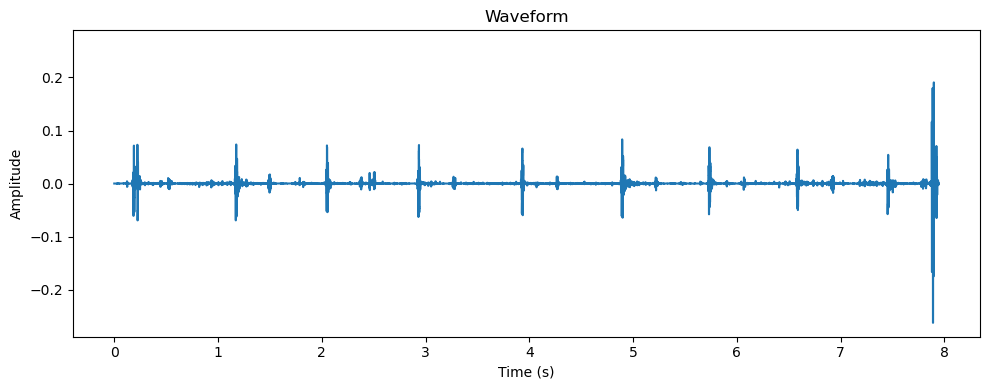

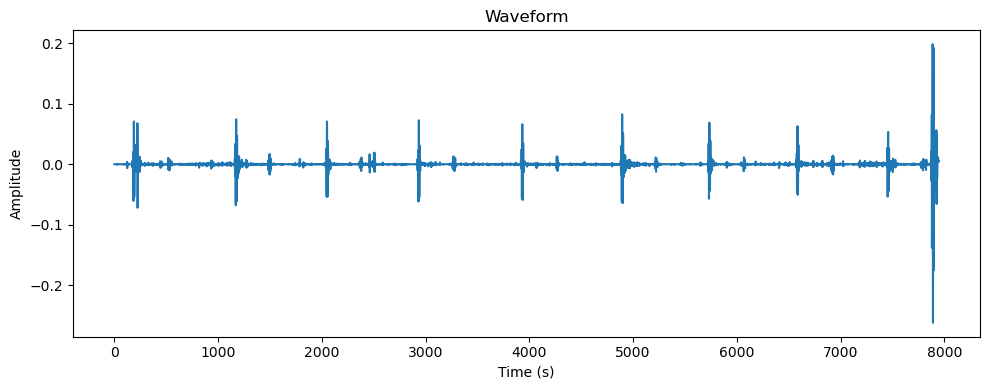

normal/201106221418.wav
NaN checking
No NaN found
normal/201103221214.wav
NaN checking
No NaN found
normal/201108011115.wav
NaN checking
No NaN found
normal/201103101140.wav
NaN checking
No NaN found
normal/201106111136.wav
NaN checking
No NaN found
normal/201102270940.wav
NaN checking
No NaN found
normal/201108011112.wav
NaN checking
No NaN found
normal/201106210943.wav
NaN checking
No NaN found
normal/201102081152.wav
NaN checking
No NaN found
normal/201108011114.wav
NaN checking
No NaN found
normal/201103140135.wav
NaN checking
No NaN found
normal/201108011118.wav
NaN checking
No NaN found
normal/201102081321.wav
NaN checking
No NaN found
normal/201105021804.wav
NaN checking
No NaN found
normal/201103170121.wav
NaN checking
No NaN found
normal/201101070538.wav
NaN checking
No NaN found
normal/201105151450.wav
NaN checking
No NaN found
normal/201106141148.wav
NaN checking
No NaN found
normal/201103090635.wav
NaN checking
No NaN found
normal/201103140822.wav
NaN checking
No NaN found


In [8]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
from scipy.signal import butter, filtfilt
import numpy as np


#Segmentation parameters
window_sec = 3
overlap_ratio = 0.5
overlap_sec = window_sec * overlap_ratio

#Preprocessing BPF parameters
lowcut = 20
highcut = 400
order = 4

def bandpass_filter(signal, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
#Signal loading
y,sr = librosa.load('normal/201103140135.wav', sr=1000)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#The same signal after BPF
bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)
plt.figure(figsize=(10, 4))
plt.plot(bpf_output)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()



#Segmentation function
def segment_signal(y, fs, window_sec, overlap_sec):
    window_len = int(window_sec * fs)
    stride_len = window_len - int(overlap_sec * fs)
    
    segments = []
    for start in range(0, len(y) - window_len + 1, stride_len):
        end = start + window_len
        segment = y[start:end]
        segments.append(segment)
    return segments



#NaNchecking
def NaN_checking(signal):
    print('NaN checking')
    if np.isnan(signal).any():
        is_nan_array = np.isnan(signal)
        nan_index = np.where(is_nan_array == True)[0]
        for index in nan_index:
            if index == 0:
                signal[index] = 0
            else:
                signal[index] = signal[index-1]
    else:
        print('No NaN found')
    return signal
    

#Amplitude thresholding,input is numpy array of preprocessed trials and labels
def artifact_trial_rejection(train_trials, threshold):
    artefact_index = []
    for i in range(len(train_trials)):
        if np.max(np.abs(train_trials[i])) > threshold:
            artefact_index.append(i)
   
    print(f'number of removed artefactual trials: {len(artefact_index)}' )

    return artefact_index


folder_path_storage = ['normal/', 'murmur/', 'artifact/']
segments_storage = []
labels_storage = []
file_ID_storage = []
fileID = 1
for folder_path in folder_path_storage:
    file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    if folder_path == 'normal/':
        label = 0
    elif folder_path == 'murmur/':
        label = 1
    elif folder_path == 'artifact/':
        label = 2

    for file in file_list:
        #Preprocessing
        print(file)
        y,sr = librosa.load(file, sr=1000)
        NaN_checked_signal = NaN_checking(y)
        bpf_output = bandpass_filter(NaN_checked_signal, lowcut, highcut, sr, order)
        segments = segment_signal(bpf_output, sr, window_sec, overlap_sec)
        for seg in segments:
            segments_storage.append(seg)
            labels_storage.append(label) 
            file_ID_storage.append(fileID)

        fileID = fileID + 1

In [9]:
#Some sanity checking
print(len(labels_storage))
print(len(segments_storage))

Trials = np.stack(segments_storage)  
Labels = np.array(labels_storage) 
File_ID = np.array(file_ID_storage) 

#print class distribution
print(f'number of normal trials: {np.sum(Labels == 0)}' )
print(f'number of murmur trials: {np.sum(Labels == 1)}' )
print(f'number of artifact trials: {np.sum(Labels == 2)}' )

def normalize_segment_zscore(segment):
    return (segment - np.mean(segment)) / (np.std(segment) + 1e-8)

for trial in Trials:
    trial = normalize_segment_zscore(trial)

451
451
number of normal trials: 122
number of murmur trials: 129
number of artifact trials: 200


In [59]:
print(File_ID)


[  1   1   1   2   3   3   3   3   4   4   4   4   4   5   5   6   6   6
   6   6   7   7   7   7   8   8   9   9   9  10  10  10  10  11  11  11
  11  12  12  12  12  13  13  13  13  14  14  14  14  14  15  15  15  15
  16  16  16  16  17  17  17  17  18  18  19  19  19  19  20  20  20  20
  21  21  21  21  21  22  22  22  22  23  23  23  23  24  24  24  24  24
  25  25  25  25  25  26  26  26  26  26  27  27  27  27  28  28  28  28
  28  29  29  29  29  29  30  30  30  30  30  31  31  31  32  32  33  33
  33  33  33  34  34  34  34  35  35  35  35  36  36  36  36  37  37  37
  37  38  38  38  38  39  39  39  39  40  40  40  40  41  41  41  41  42
  42  42  42  43  43  43  43  45  45  45  45  46  46  46  47  47  47  47
  48  48  48  48  49  49  49  49  50  50  50  50  51  51  52  52  52  52
  53  53  53  53  54  54  54  54  54  55  55  55  55  56  56  56  56  57
  57  57  57  58  58  58  58  59  59  59  59  60  60  60  60  61  61  61
  61  62  62  62  62  63  63  63  63  64  64  64  6

In [11]:
#Features extraction
from scipy.signal import hilbert, find_peaks
from scipy.stats import entropy as scipy_entropy
from scipy.signal import savgol_filter
from scipy.signal import welch
from scipy.signal import find_peaks


#number of envelope peaks, peak-to-peak amp, entropy, RMS Energy, mean and variance of the envelope
def extract_time_domain_features(signal, sr):
    envelope = np.abs(hilbert(signal))
    #number of peaks or dominant frequency of the envelope
    smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)
    envelope_mean = np.mean(smoothed_env)
    envelope_variance = np.var(smoothed_env)
    

    N = len(smoothed_env)
    freqs = np.fft.rfftfreq(N, 1/sr)
    fft_vals = np.abs(np.fft.rfft(smoothed_env))
    #cardiac cycle rate
    envelope_dom_freq = freqs[np.argmax(fft_vals[1:]) + 1] 

    #number of peaks on envelope
    peaks, _ = find_peaks(smoothed_env, height=0.5 * np.max(smoothed_env))
    envelope_peaks = len(peaks)
    
    rms_energy = np.sqrt(np.mean(signal ** 2))

    p2p = np.max(signal) - np.min(signal)

    hist, bin_edges = np.histogram(signal, bins=50, density=True)
    signal_entropy = scipy_entropy(hist + 1e-8)  


    return np.array([envelope_mean, envelope_variance, envelope_dom_freq, p2p, rms_energy, signal_entropy, envelope_peaks])

#Bandwidth. Bandpowers. 
def extract_frequency_domain_features(signal, sr):
    freqs_psd, psd = welch(signal, fs=sr, nperseg=1024)
    freq_res = freqs_psd[1] - freqs_psd[0]

    band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
    band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

    bp_25_150 = np.sum(psd[band_25_150]) * freq_res
    bp_150_400 = np.sum(psd[band_150_400]) * freq_res
    bandpower_ratio = bp_150_400/(bp_25_150 + 1e-8)

    centroid = np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8)
    bandwidth = np.sqrt(np.sum(((freqs_psd - centroid) ** 2) * psd) / (np.sum(psd) + 1e-8))

    dominant_freq = freqs_psd[np.argmax(psd[1:]) + 1]

    #Spectral entropy
    norm_psd = psd / np.sum(psd)
    spectral_entropy = scipy_entropy(norm_psd)

    return np.array([bandpower_ratio, bandwidth, dominant_freq, spectral_entropy])

features = []
for trial in Trials: 
    time_features = extract_time_domain_features(trial, sr=1000)
    freq_features = extract_frequency_domain_features(trial, sr=1000)
    features_vector = np.concatenate((time_features, freq_features))
    features.append(features_vector)

features = np.stack(features)


In [29]:
import random
from sklearn.model_selection import StratifiedShuffleSplit

#sanity checking
print('shape of features:', features.shape)


file_level_splitting = True

if file_level_splitting == False:
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=100)
    for train_idx, test_idx in sss.split(features, Labels):
        train_set, test_set = features[train_idx], features[test_idx]
        train_set_labels, test_set_labels = Labels[train_idx], Labels[test_idx]
        
    print('shape of train set:', train_set.shape)
    print('shape of test set:', test_set.shape)


else: 

    unique_files, file_indices = np.unique(File_ID, return_index=True)
    file_labels = Labels[file_indices]  
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=100)
    for train_file_idx, test_file_idx in sss.split(unique_files, file_labels):
        train_file_ids = unique_files[train_file_idx]
        test_file_ids = unique_files[test_file_idx]
    
    train_mask = np.isin(File_ID, train_file_ids)
    test_mask = np.isin(File_ID, test_file_ids)
    
    train_set = features[train_mask]
    train_set_labels = Labels[train_mask]
    train_files = File_ID[train_mask]
    test_set = features[test_mask]
    test_set_labels = Labels[test_mask]
    test_files = File_ID[test_mask]
    
    # Sanity check
    print('shape of train set:', train_set.shape)
    print('shape of test set:', test_set.shape)

shape of features: (451, 11)
shape of train set: (359, 11)
shape of test set: (92, 11)


In [30]:
print(File_ID[test_mask])
print(train_set_labels)
print(train_file_ids)


[  4   4   4   4   4   8   8   9   9   9  16  16  16  16  24  24  24  24
  24  25  25  25  25  25  35  35  35  35  36  36  36  36  39  39  39  39
  52  52  52  52  60  60  60  60  62  62  62  62  64  64  64  64  66  66
  66  66  66  70  70  70  70  70  80  80  80  80  80  83  83  83  83  83
  85  85  85  85  85  93  93  93  93  93  96  96  96  96  96 102 102 102
 102 102]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [31]:
#Amplitude thresholding on training data
peak_amps = [np.max(np.abs(trial)) for trial in Trials[train_mask]]
threshold = np.percentile(peak_amps, 99.5)
print(threshold)
artifact_trials =  artifact_trial_rejection(Trials[train_mask],threshold)
train_set = np.delete(train_set, artifact_trials, axis = 0)
train_set_labels = np.delete(train_set_labels, artifact_trials)
train_files = np.delete(train_files, artifact_trials)
print('shape of train set:', train_set.shape)

1.0313265005684278
number of removed artefactual trials: 2
shape of train set: (357, 11)


In [32]:
#Normalize features (z scoring)
#number_of_features = train_set.shape[1]

#for feature_id in range (number_of_features):
#    feature_mean = np.mean(train_set[:,feature_id])
#    feature_std = np.std(train_set[:,feature_id], ddof=0)
#    #normalize
#    train_set[:,feature_id] = (train_set[:,feature_id] - feature_mean) / feature_std
#    test_set[:,feature_id] = (test_set[:,feature_id] - feature_mean) / feature_std
#    val_set[:,feature_id] = (val_set[:,feature_id] - feature_mean) / feature_std


In [33]:
#Model building (SVM)
import optuna
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold

print(f'Train set shape: {train_set.shape}')

def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['svm', 'xgboost'])
    
    if file_level_splitting == True:
        skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(train_set, train_set_labels, groups=train_files)
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(train_set, train_set_labels)
        
    
    f1_scores = []

    if model_type == 'svm':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        gamma = 'scale' if kernel == 'linear' else trial.suggest_float('gamma', 1e-4, 1e1, log=True)
        w0 = trial.suggest_float('w0', 0.1, 10.0)
        w1 = trial.suggest_float('w1', 0.1, 10.0)
        w2 = trial.suggest_float('w2', 0.1, 10.0)
        class_weights = {0: w0, 1: w1, 2: w2}
        
    else:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    for train_idx, val_idx in split_generator:
        X_train, X_val = train_set[train_idx], train_set[val_idx]
        y_train, y_val = train_set_labels[train_idx], train_set_labels[val_idx]

        # Normalize
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        if model_type == 'svm':
            clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weights)
        else:
            clf = xgb.XGBClassifier(
                objective='multi:softprob',
                num_class=3,
                use_label_encoder=False,
                eval_metric='mlogloss',
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                scale_pos_weight=1
            )

        clf.fit(X_train, y_train)
        if model_type == 'xgboost':
            y_pred = np.argmax(clf.predict_proba(X_val), axis=1)
        else:
            y_pred = clf.predict(X_val)

        f1 = f1_score(y_val, y_pred, average='macro')
        #f1 = f1_score(y_val, y_pred, labels=[0, 1], average='macro')
        
        true_healthy_idx = np.where(y_val == 0)[0]
        if len(true_healthy_idx) > 0:
            num_healthy_misclassified_as_murmur = np.sum(y_pred[true_healthy_idx] == 1)
            fpr_healthy_to_murmur = num_healthy_misclassified_as_murmur / len(true_healthy_idx)

        f1_scores.append(f1)

    return np.mean(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


[I 2025-06-24 23:12:24,299] A new study created in memory with name: no-name-982481c6-b5f2-46b4-b14b-a05486c65408


Train set shape: (357, 11)


/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:12:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:12:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:12:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update

In [51]:
print(type(split_generator))

NameError: name 'split_generator' is not defined

In [42]:
#secondary classifier

def objective_secondary(trial):
    model_type = trial.suggest_categorical('model_type', ['svm', 'xgboost'])
    
    if model_type == 'svm':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        gamma = 'scale' if kernel == 'linear' else trial.suggest_float('gamma', 1e-4, 1e1, log=True)
        w0 = trial.suggest_float('w0', 0.1, 10.0)
        w1 = trial.suggest_float('w1', 0.1, 10.0)
        class_weights = {0: w0, 1: w1}
        
    else:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
            
    binary_mask = np.isin(train_set_labels, [0,1])
    binary_train_set = train_set[binary_mask]
    binary_train_labels = train_set_labels[binary_mask]
    
    if file_level_splitting == True:
        skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(binary_train_set, binary_train_labels, groups=train_files[binary_mask])
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(binary_train_set, binary_train_labels)
        
    f1_scores = []
    
    for train_idx, val_idx in split_generator:
        X_train, X_val = binary_train_set[train_idx], binary_train_set[val_idx]
        y_train, y_val = binary_train_labels[train_idx], binary_train_labels[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        if model_type == 'svm':
            clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weights)
        else:
            clf = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='mlogloss',
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            scale_pos_weight=1
            )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        #f1 = f1_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, labels=[0, 1], average='macro')
        accuracy = accuracy_score(y_val, y_pred)
        
        true_healthy_idx = np.where(y_val == 0)[0]
        num_healthy = len(true_healthy_idx)
        num_healthy_misclassified_as_murmur = np.sum(y_pred[true_healthy_idx] == 1)
        fpr_healthy_to_murmur = num_healthy_misclassified_as_murmur / num_healthy

        true_murmur_idx = np.where(y_val == 1)[0]
        num_murmur = len(true_murmur_idx)
        num_murmur_misclassified_as_healthy = np.sum(y_pred[true_murmur_idx] == 0)
        fpr_murmur_to_healthy = num_murmur_misclassified_as_healthy / num_murmur
        
        f1_scores.append(f1)

    return np.mean(f1_scores)

study_secondary_classifier = optuna.create_study(direction='maximize')
study_secondary_classifier.optimize(objective_secondary, n_trials=70)

[I 2025-06-24 23:22:15,649] A new study created in memory with name: no-name-a5f7b7f9-bdad-4831-94ff-3661d03c5e02
[I 2025-06-24 23:22:15,669] Trial 0 finished with value: 0.32560224089635853 and parameters: {'model_type': 'svm', 'C': 0.036875000009741137, 'kernel': 'rbf', 'gamma': 3.005134685618211, 'w0': 3.8496762530058835, 'w1': 2.5076310847339593}. Best is trial 0 with value: 0.32560224089635853.
/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:22:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:22:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not 

Test macro F1: 0.8513768598711969
Overall test accuracy: 0.8695652173913043
test accuracy healthy: 0.75
healthy sample size: 24
test accuracy murmur: 0.8571428571428571
murmur sample size: 28
test accuracy artifact: 0.95
artifact sample size: 40


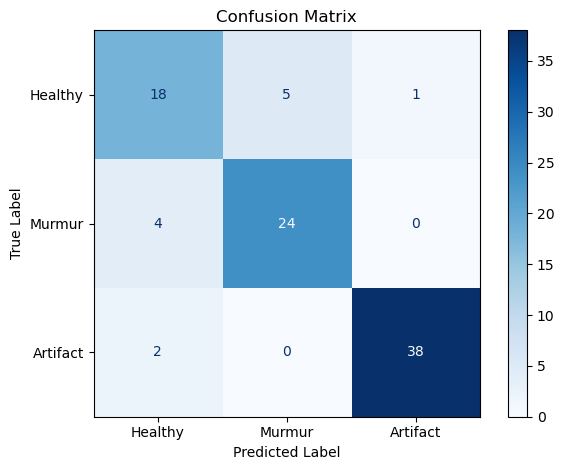

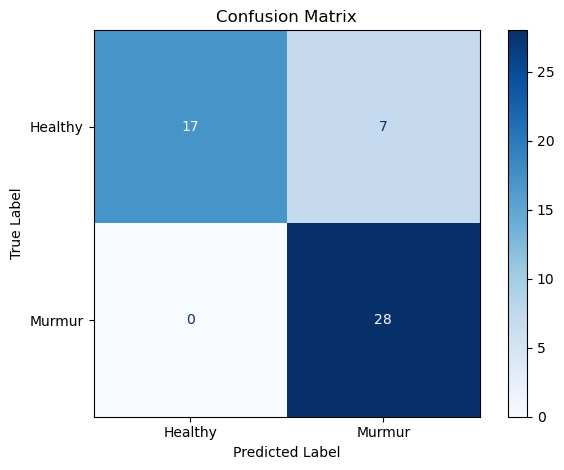

In [43]:
#Fit scaler on the full training set
#Retrain using best hyperparameters
#Evaluate: Test set performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
normalized_train_set = scaler.fit_transform(train_set)
normalized_test_set = scaler.transform(test_set)

model_type = study.best_params['model_type']

if model_type == 'svm':
    if study.best_params['kernel'] == 'linear':
        gamma_value = 'scale'  # or whatever you used as default
    else:
        gamma_value = study.best_params['gamma']
    
    class_weight = {
            0: study.best_params['w0'],
            1: study.best_params['w1'],
            2: study.best_params['w2']
        }
    clf = SVC(
        C=study.best_params['C'],
        kernel=study.best_params['kernel'],
        gamma=gamma_value,
        class_weight=class_weight
    )
elif model_type == 'xgboost':
    clf = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        max_depth=study.best_params['max_depth'],
        learning_rate=study.best_params['learning_rate'],
        n_estimators=study.best_params['n_estimators'],
        subsample=study.best_params['subsample'],
        colsample_bytree=study.best_params['colsample_bytree'],
        scale_pos_weight=1  
    )

clf.fit(normalized_train_set, train_set_labels)

if model_type == 'xgboost':
    test_set_predict = np.argmax(clf.predict_proba(normalized_test_set), axis=1)
else:
    test_set_predict = clf.predict(normalized_test_set)

test_f1 = f1_score(test_set_labels, test_set_predict, average='macro')
print("Test macro F1:", test_f1)

accuracy = accuracy_score(test_set_labels, test_set_predict)
print("Overall test accuracy:", accuracy)

healthy_index = np.where(test_set_labels == 0)[0]
accuracy = accuracy_score(test_set_labels[healthy_index], test_set_predict[healthy_index])
print("test accuracy healthy:", accuracy)
print("healthy sample size:", len(healthy_index))
murmur_index = np.where(test_set_labels == 1)[0]
accuracy = accuracy_score(test_set_labels[murmur_index], test_set_predict[murmur_index])
print("test accuracy murmur:", accuracy)
print("murmur sample size:", len(murmur_index))
artifact_index = np.where(test_set_labels == 2)[0]
accuracy = accuracy_score(test_set_labels[artifact_index], test_set_predict[artifact_index])
print("test accuracy artifact:", accuracy)
print("artifact sample size:", len(artifact_index))

#Confusion matrix 
cm = confusion_matrix(test_set_labels, test_set_predict, labels=[0,1,2])
class_names = ['Healthy', 'Murmur', 'Artifact']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#testing performance of secondary binary classifier
model_type = study_secondary_classifier.best_params['model_type']
if model_type == 'svm':
    if study_secondary_classifier.best_params['kernel'] == 'linear':
        gamma_value = 'scale' 
    else:
        gamma_value = study_secondary_classifier.best_params['gamma']
    
    class_weight = {
            0: study_secondary_classifier.best_params['w0'],
            1: study_secondary_classifier.best_params['w1']
        }
    clf = SVC(
        C=study_secondary_classifier.best_params['C'],
        kernel=study_secondary_classifier.best_params['kernel'],
        gamma=gamma_value,
        class_weight=class_weight
    )
elif model_type == 'xgboost':
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='mlogloss',
        max_depth=study_secondary_classifier.best_params['max_depth'],
        learning_rate=study_secondary_classifier.best_params['learning_rate'],
        n_estimators=study_secondary_classifier.best_params['n_estimators'],
        subsample=study_secondary_classifier.best_params['subsample'],
        colsample_bytree=study_secondary_classifier.best_params['colsample_bytree'],
        scale_pos_weight=1  
    )
binary_mask = np.isin(train_set_labels, [0,1])
binary_train_set = normalized_train_set[binary_mask]
binary_train_labels = train_set_labels[binary_mask]
clf.fit(binary_train_set, binary_train_labels)
binary_mask = np.isin(test_set_labels, [0,1])
binary_test_set = normalized_test_set[binary_mask]
binary_test_labels = test_set_labels[binary_mask]
test_set_predict = clf.predict(binary_test_set)

cm = confusion_matrix(binary_test_labels, test_set_predict, labels=[0,1])
class_names = ['Healthy', 'Murmur']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

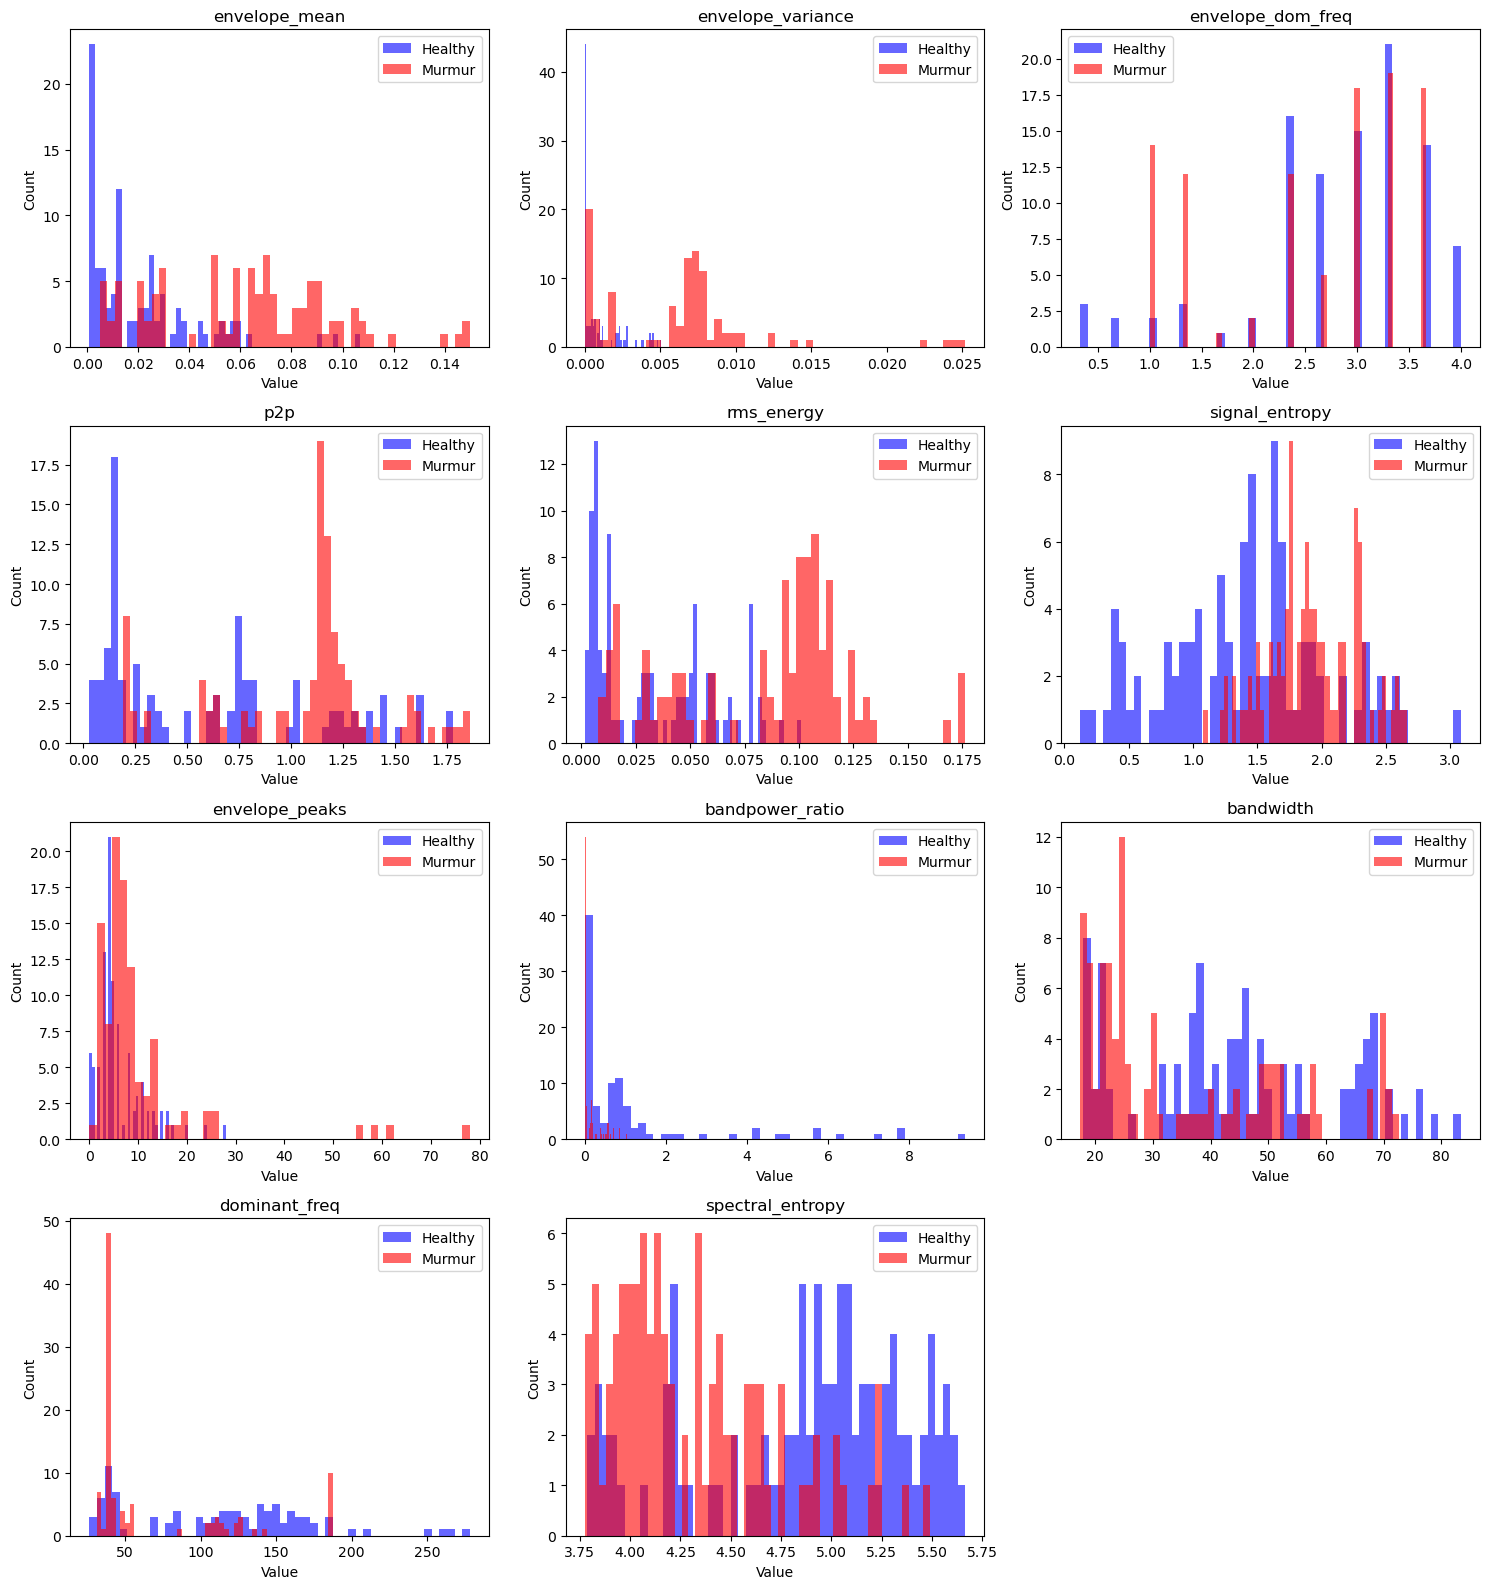

-1.4298825275582716
-1.3598146022386615
0.2813453220956655
-0.9601294265559026
-1.484482497521143
-1.0095782062182372
-0.41654725878347093
0.7338937553586465
0.5507330836303719
0.7865020198090888
1.2174571351552446


In [53]:
# Features analyses (most for informing about future work)
#conclusion: some features may not be informative
#for those ones that are informative, how to engineer variants of 

#Histogram of each feature murmur vs healthy 
n_features = train_set.shape[1]
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

feature_names = ['envelope_mean', 'envelope_variance', 'envelope_dom_freq', 'p2p', 'rms_energy', 'signal_entropy', 'envelope_peaks', 
                'bandpower_ratio', 'bandwidth', 'dominant_freq', 'spectral_entropy']

for feature_id in range (train_set.shape[1]):
    feature_healthy = train_set[train_set_labels == 0,feature_id]
    feature_murmur = train_set[train_set_labels == 1,feature_id]
    plt.subplot(n_rows, n_cols, feature_id + 1)
    plt.hist(feature_healthy, bins=50, alpha=0.6, label='Healthy', color='blue')
    plt.hist(feature_murmur, bins=50, alpha=0.6, label='Murmur', color='red')
    plt.title(feature_names[feature_id])
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

#Feature selection: model-driven feature importance using XGBoost. (no need to do this, just have this as an option)

#Statistically, are features separable between classes:
def cohen_d(x1, x2):
    return (np.mean(x1) - np.mean(x2)) / np.sqrt((np.std(x1)**2 + np.std(x2)**2)/2)

for feature_id in range (train_set.shape[1]):
    feature_healthy = train_set[train_set_labels == 0,feature_id]
    feature_murmur = train_set[train_set_labels == 1,feature_id]
    print(cohen_d(feature_healthy, feature_murmur))

#Analyses on the trials that are classified incorrectly

In [45]:
print(train_set.shape[1)

11


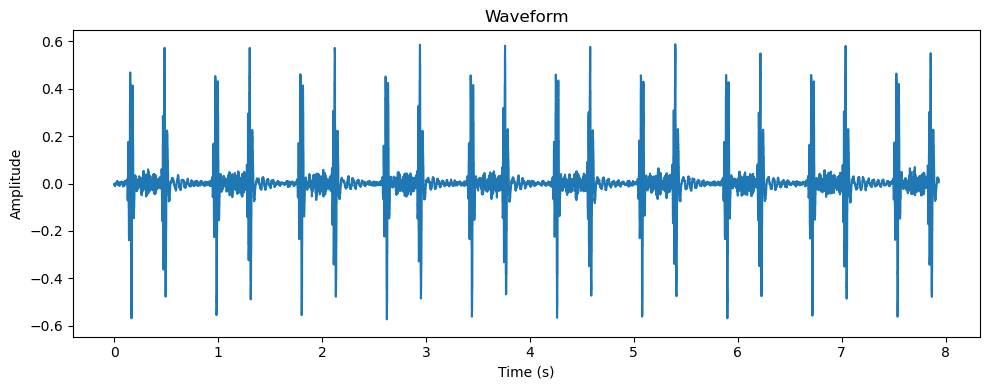

numnber of peaks: 20


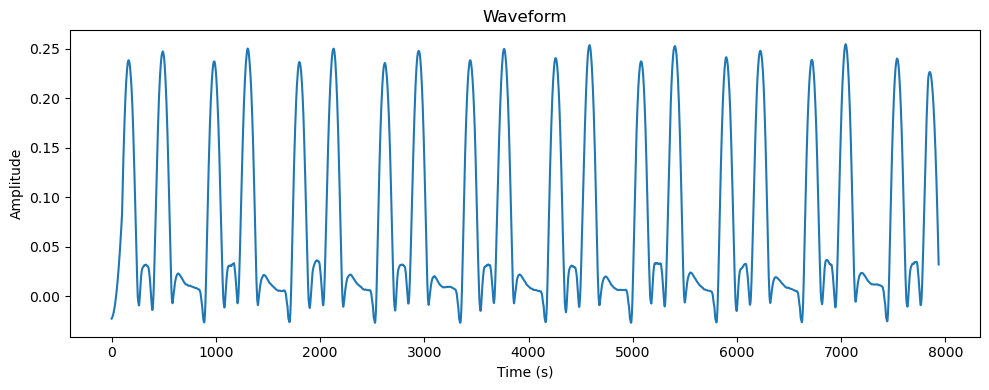

3.654233870967742
1.9475097793144278
0.018362202749769147
48.13362325990542


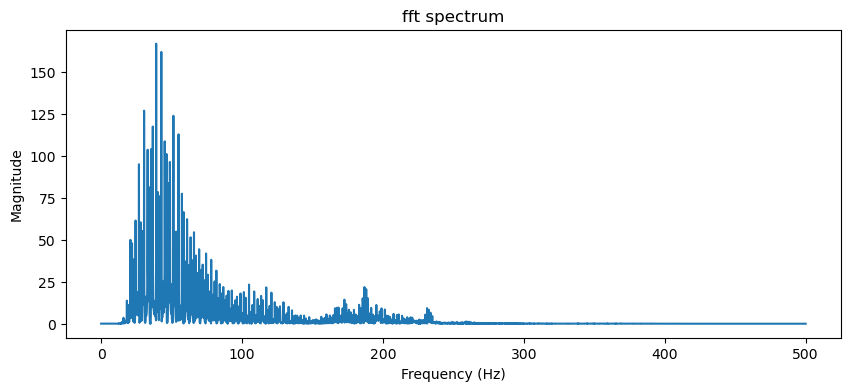

In [28]:
#Example envelope waveform

from scipy.signal import hilbert, find_peaks
from scipy.signal import savgol_filter
from scipy.stats import entropy as scipy_entropy
from scipy.signal import welch

y,sr = librosa.load('murmur/201108222231.wav', sr=1000)
y,sr = librosa.load('murmur/201108222232.wav', sr=1000)
y,sr = librosa.load('normal/201105021654.wav', sr=1000)
y,sr = librosa.load('murmur/201108222237.wav', sr=1000)

bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(bpf_output, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

envelope = np.abs(hilbert(bpf_output))
smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)

peaks, _ = find_peaks(smoothed_env, height=0.5 * np.max(smoothed_env))
envelope_peaks = len(peaks)
print('numnber of peaks:', envelope_peaks)

plt.figure(figsize=(10, 4))
plt.plot(smoothed_env)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

N = len(smoothed_env)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(smoothed_env))
dom_freq = freqs[np.argmax(fft_vals[1:]) + 1]  # skip DC
print(dom_freq)

hist, bin_edges = np.histogram(bpf_output, bins=50, density=True)
signal_entropy = scipy_entropy(hist + 1e-8)  # Avoid log(0)
print(signal_entropy)


#plotting fft spectrum
N = len(bpf_output)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(bpf_output))
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals)
plt.title('fft spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

freqs_psd, psd = welch(bpf_output, fs=sr, nperseg=1024)
freq_res = freqs_psd[1] - freqs_psd[0]

band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

bp_25_150 = np.sum(psd[band_25_150]) * freq_res
bp_150_400 = np.sum(psd[band_150_400]) * freq_res
print(bp_150_400/bp_25_150)
print(np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8))

0.1593233530012803
67.39073711423882


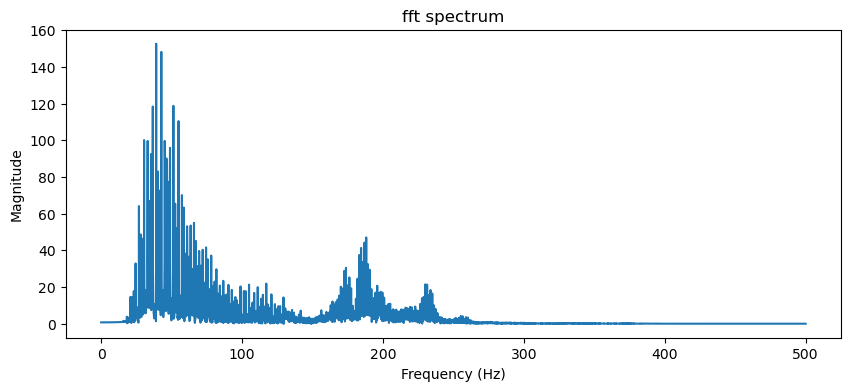

In [5]:
y,sr = librosa.load('murmur/201108222231.wav', sr=1000)
bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)
N = len(bpf_output)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(bpf_output))
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals)
plt.title('fft spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

freqs_psd, psd = welch(bpf_output, fs=sr, nperseg=1024)
freq_res = freqs_psd[1] - freqs_psd[0]

band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

bp_25_150 = np.sum(psd[band_25_150]) * freq_res
bp_150_400 = np.sum(psd[band_150_400]) * freq_res
print(bp_150_400/bp_25_150)
print(np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8))